# Modulacion de palabras para clasificación

In [2]:
#Importamos algunas librerias necesarias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
from nltk.tokenize import word_tokenize
import we_to_signal as wes

[nltk_data] Downloading package punkt to /home/ulises/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/ulises/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Modulacion

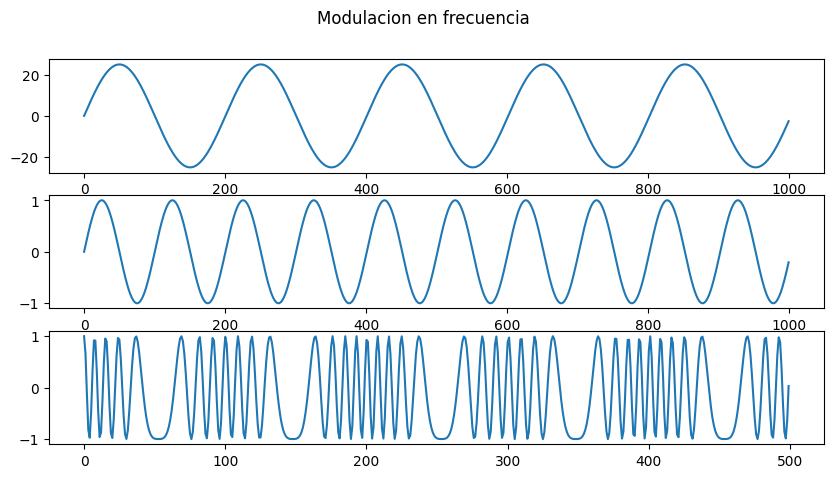

In [5]:
# Samples per second
sps = 44100

# Duration
duration_s = 5.0

# ac: amplitude of the carrier. Should be kept at 1.0 in this script
# you would modify it if you were micing it with, or modulating other,
# waveforms.

# carrier_hz: Frequency of the carrier
# fm_hz: Frequency of the frequency modulator
# k_p: deviation constant
carrier_amplitude = 1.0
carrier_hz = 440.0
fm_hz = 220.0
k = 25.0

# Our final waveform is going to be calculated as the cosine of carrier and
# frequency modulated terms.

# First, define our range of sample numbers
each_sample_number = np.arange(duration_s * sps)

# Create the term that create the carrier
carrier = 2 * np.pi * each_sample_number * carrier_hz / sps

# Now create the term that is the frequency modulator
modulator = k * np.sin(2 * np.pi * each_sample_number * fm_hz / sps)

# Now create the modulated waveform, and attenuate it
waveform = np.cos(carrier + modulator)
waveform_quiet = waveform * 0.3

fig,ax = plt.subplots(3,figsize=(10,5))

fig.suptitle("Modulacion en frecuencia")
ax[0].plot(modulator[:1000])
ax[1].plot(np.sin(carrier[:1000]))
ax[2].plot(waveform[:500])

## Carga de corpus y calculo de embbeddings

In [6]:
#Con los poemas separados, los metemos en un diccionario de dataframes
import os

data_path = "data/"
emotion_list = ["anger", "anticipation", "disgust", "fear", "joy", "sadness", "surprise", "trust"]

json_files = sorted([pos_json for pos_json in os.listdir(data_path) if pos_json.endswith('.json')])
json_files.remove('Poems.json')
json_files.remove('missing.json')

em_poems = {}
for e in emotion_list:
    f = open(data_path+e+".json")
    df_ = pd.DataFrame(json.load(f))
    em_poems[e] = df_
em_poems["anger"]

,poem,id
0,i do know this it's nothing i can hold\nlast ...,10
1,the fear o' hell's a hangman's whip\nto haud t...,18
2,but since i laid a hand thereon\nand found a h...,88
3,falsely i pointed to sum in text\nseriously he...,99
4,i'll wear my jealous reflection\njuice of lemo...,125
...,...,...
2461,new snow on a leaf\nlike granulated sugar\nmak...,93124
2462,new earth and old earth\na trio of guardians\n...,93138
2463,destructions despair\nconstructions hope toge...,93217
2464,hot dry summers will\nbake paint right off the...,93226


In [7]:
#Carga de embeddings
from gensim.models import Word2Vec
from gensim.models import FastText

emotion_list = ["anger", "anticipation", "disgust", "fear", "joy", "sadness", "surprise", "trust"]

poems_w2v = {}
poems_fst = {}

for e in emotion_list:
    w2v_lines = Word2Vec.load("embeddings_poems/w2v_model_"+e)
    fst_lines = FastText.load("embeddings_poems/fst_model_"+e)
    poems_w2v[e] = w2v_lines
    poems_fst[e] = fst_lines

## Simulitud de palabras entre emociones

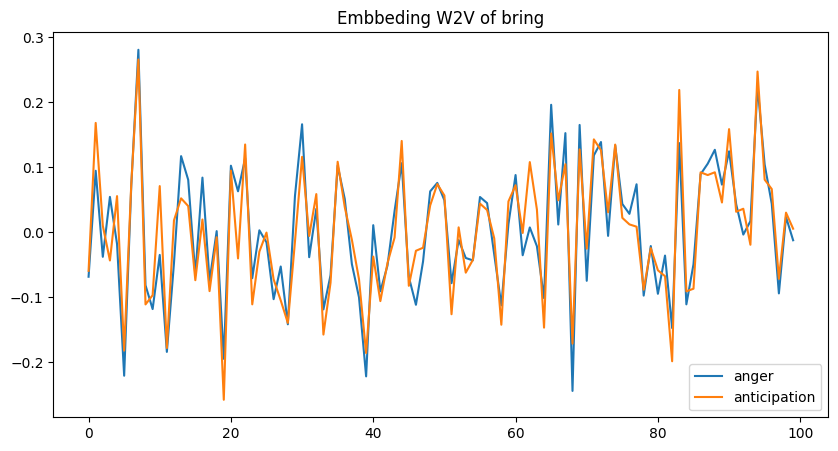

In [8]:
#Parametros
word = "bring"
emotion_a = "anger"
emotion_b = "anticipation"

#Extraccion del embbeding
embbeding_emotion_a = poems_w2v[emotion_a].wv.get_vector(word,norm=True)
embbeding_emotion_b = poems_w2v[emotion_b].wv.get_vector(word,norm=True)

plt.figure(figsize=(10,5))
plt.title("Embbeding W2V of "+word)
plt.plot(embbeding_emotion_a)
plt.plot(embbeding_emotion_b)
plt.legend([emotion_a,emotion_b])

PearsonRResult(statistic=0.9157850532955004, pvalue=1.323292927356247e-40)

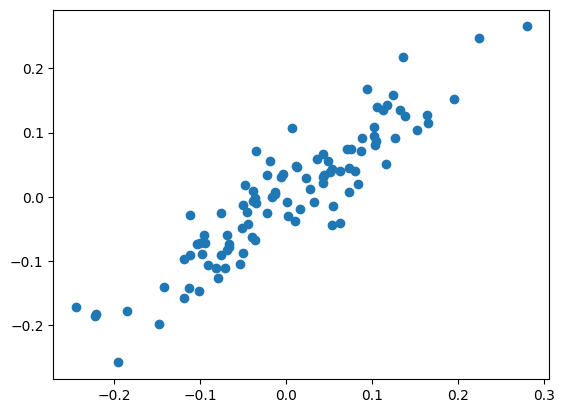

In [12]:
#Scatter plot para observar su correlación y correlacion pearson
from scipy.stats import pearsonr

plt.scatter(embbeding_emotion_a,embbeding_emotion_b)
display(pearsonr(embbeding_emotion_a,embbeding_emotion_b))

In [14]:
#Calculamos la interseccion entre palabras de fst,w2v y todas las emociones

words_intersection = set()
for emotion in emotion_list:
    fst = set(poems_fst[emotion].wv.key_to_index.keys())
    w2v = set(poems_w2v[emotion].wv.key_to_index.keys())
    intersection = fst & w2v
    if not words_intersection:
        words_intersection = words_intersection.union(intersection)
    else:
        words_intersection = words_intersection.intersection(intersection)

display(len(words_intersection))

677

In [15]:
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
words_intersection = words_intersection - stop_words
len(words_intersection)

562

In [17]:
#Funciones de procesamiento y obtencion de frecuencia de las palabras
from collections import Counter

def get_word_freq(dataframe:pd.DataFrame,col:str,emotion_list:list):
    """
    Calculates for Counter model of each emotion text corpus.

    Parameters
    ------------
    dataframe: pandas Dataframe with documents.
    col:str name of the column where the documents are.
    emotion_list: list with emotions

    Returns
    -----------
    dict:
        dictionary with keys(emotions_list) an each key with his self Counter model.
    """
    freq_dict = {}
    for emotion in emotion_list:
        tokens = dataframe[emotion][col].apply(lambda x: [token for token in word_tokenize(x)])
        l1 = tokens.values.tolist()
        l2 = [w for l in l1 for w in l ]
        freq_dict[emotion] = Counter(l2)
    return freq_dict

def text_clean(sent):
    """
    Clean the text of some chars
    
    Parameters
    -------------
    sent: str
        Sentence to be cleaned
    
    Returns
    -------------
    str:
        Sentence cleaned.
    """
    import re
    from unidecode import unidecode
    import unicodedata as ud

    d = {ord('\N{combining acute accent}'):None}
    sent = ud.normalize('NFD',sent).translate(d)
    sent = re.sub(r"[^\w .,;?!\n]+", "", sent)
    sent = re.sub(r"[^\w .,;?!]", " ", sent)
    sent = re.sub(r"[^\w .,]", ".", sent)
    sent = re.sub(r"[^\w ]", "", sent)
    sent = re.sub(r"[0-9]", "", sent)
    sent = re.sub(r"[α-ωςϑϕϜϝϞϠϰϱ]", "", sent)
    sent = re.sub(r"[ΓΔΕΖΗΘΙΚΛΜΝΞΟΠΡΣΤΥΦΧΨΩ]", "", sent)
    sent = re.sub(r"[A-Z]{2}", "", sent)
    return sent

In [19]:
#Creamos una copia de los poemas y calculamos la frecuencia de aparición de las palabras
em_poem_c = dict()

for emotion in emotion_list:
    em_poem_c[emotion] = em_poems[emotion].copy()

for emotion in emotion_list:
    em_poem_c[emotion]["poems_clean"] = em_poem_c[emotion]["poem"].apply(text_clean)

freq_dict = get_word_freq(em_poem_c,"poems_clean",emotion_list)

In [23]:
#Creamos el dataframe de las palabras con su correlacion pearson
from itertools import combinations

def create_correlation_df(models,emotion_list,words_intersection,freq_dict):
    emotion_combinations = list(combinations(emotion_list,2))

    words_embbed_info = {}
    words_embbed_info["words"] = list(words_intersection)

    for emotion in emotion_list:
        words_embbed_info["f_"+emotion] = []

    for comb in emotion_combinations:
        words_embbed_info["P_"+str(comb)] = []

    for word in words_intersection:
        #Añadimos la frecuencia por cada emoción
        for emotion in emotion_list:
            words_embbed_info["f_"+emotion].append(freq_dict[emotion][word])

        #Calculamos la correlacion pearson para cada par de emociones.    
        for comb in emotion_combinations:
            emotion_a = comb[0]
            emotion_b = comb[1]

            words_embbed_info["P_"+str(comb)].append(pearsonr(models[emotion_a].wv.get_vector(word,norm=True),models[emotion_b].wv.get_vector(word,norm=True)))

    return pd.DataFrame(words_embbed_info)

In [24]:
words_embbed_w2v_info = create_correlation_df(poems_w2v,emotion_list,words_intersection,freq_dict)
words_embbed_fst_info = create_correlation_df(poems_fst,emotion_list,words_intersection,freq_dict)

display(words_embbed_w2v_info)
display(words_embbed_fst_info)

,words,f_anger,f_anticipation,f_disgust,f_fear,f_joy,f_sadness,f_surprise,f_trust,"P_('anger', 'anticipation')",...,"P_('fear', 'joy')","P_('fear', 'sadness')","P_('fear', 'surprise')","P_('fear', 'trust')","P_('joy', 'sadness')","P_('joy', 'surprise')","P_('joy', 'trust')","P_('sadness', 'surprise')","P_('sadness', 'trust')","P_('surprise', 'trust')"
0,winter,20,110,14,35,96,95,8,92,"(0.9003144955676535, 3.5093991897405127e-37)",...,"(0.8491519556063901, 6.377805071462181e-29)","(0.8863999382916747, 1.4997449673857111e-34)","(0.8783787054596531, 3.4762156902632926e-33)","(0.8661081099238506, 2.8384067969071495e-31)","(0.8907461491188048, 2.4704184550448737e-35)","(0.8752094807285311, 1.1327337671687337e-32)","(0.8728412215251684, 2.681974137567959e-32)","(0.8930295557116268, 9.287436250586495e-36)","(0.8954118810088219, 3.2676873309206644e-36)","(0.8633926648130901, 7.090577398381073e-31)"
1,half,18,82,11,72,78,88,6,101,"(0.9122667673149776, 9.018699987312133e-40)",...,"(0.8643504045998261, 5.145496813710872e-31)","(0.8833838085273649, 5.023915390349419e-34)","(0.8673821396912014, 1.8344931260302735e-31)","(0.8869324369149502, 1.2072109593368502e-34)","(0.8822220690163517, 7.932627350824856e-34)","(0.8606074493422582, 1.7771650081451334e-30)","(0.880925761371019, 1.3131642864592902e-33)","(0.903038677166952, 9.655986949628502e-38)","(0.8977332449767148, 1.1522441940900762e-36)","(0.8756441357635486, 9.651593348343962e-33)"
2,put,28,88,19,65,85,74,14,121,"(0.9104835584830911, 2.313743172532515e-39)",...,"(0.8544224992649649, 1.2758485968216063e-29)","(0.8850386590570974, 2.5989350321704847e-34)","(0.8825203810611778, 7.057944057860564e-34)","(0.8871061002623153, 1.1244714775054583e-34)","(0.8885804571678578, 6.125178207188778e-35)","(0.8896595192545755, 3.9053651759773023e-35)","(0.8925416588468658, 1.1467855337346889e-35)","(0.9078352735635268, 9.046181957953626e-39)","(0.9011017844953118, 2.4262901131746958e-37)","(0.890085804341736, 3.2650186688646075e-35)"
3,gold,27,109,19,65,169,91,18,159,"(0.8846916794296666, 2.986595761683603e-34)",...,"(0.8166077829637762, 3.9858714206575766e-25)","(0.8749422736160117, 1.2495176381349546e-32)","(0.8845381542897377, 3.1756377279429826e-34)","(0.855581708499043, 8.879607042221654e-30)","(0.8687705079473115, 1.1342206389477076e-31)","(0.8710921878876805, 5.013393882717418e-32)","(0.841174974604483, 6.504914160075975e-28)","(0.8962305531119574, 2.268888887447944e-36)","(0.8833076463575337, 5.1774030436011964e-34)","(0.8567127118042782, 6.2156957619341424e-30)"
4,thats,15,61,17,41,120,61,17,120,"(0.9085013840848716, 6.444995269169251e-39)",...,"(0.8605645781450363, 1.8021976559615675e-30)","(0.8777442830720936, 4.415114772964908e-33)","(0.8797557190568561, 2.059320941958018e-33)","(0.8829547108297804, 5.9505651001759154e-34)","(0.8830753354776062, 5.674414807707648e-34)","(0.8891766329144783, 4.7794708080993154e-35)","(0.8969570958189438, 1.6372042116775086e-36)","(0.8992889198620196, 5.64995137866385e-37)","(0.8949683111389124, 3.976779558886808e-36)","(0.8964303457019063, 2.0746702102701288e-36)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
557,soft,19,105,12,56,205,91,12,80,"(0.9014378291447901, 2.0706869618540997e-37)",...,"(0.8202679320980293, 1.6310218856665696e-25)","(0.8762152773913449, 7.813402831306456e-33)","(0.8900632904707376, 3.29610735209884e-35)","(0.8645013875764753, 4.890774904547986e-31)","(0.8716649120519292, 4.0889247367034494e-32)","(0.8803578336491334, 1.6346392118919916e-33)","(0.8574709954274901, 4.885272796789555e-30)","(0.9022509830442392, 1.4077833675052635e-37)","(0.891629504211896, 1.6964132579938936e-35)","(0.867955994216672, 1.5048457029172272e-31)"
558,already,9,51,5,23,27,39,7,47,"(0.9110614306887351, 1.70868151808758e-39)",...,"(0.8553063714187265, 9.680659164014863e-30)","(0.8883117237673255, 6.846728431514376e-35)","(0.8661374181079436, 2.810191194839954e-31)","(0.8730154424409533, 2.518681465437633e-32)","(0.88

,words,f_anger,f_anticipation,f_disgust,f_fear,f_joy,f_sadness,f_surprise,f_trust,"P_('anger', 'anticipation')",...,"P_('fear', 'joy')","P_('fear', 'sadness')","P_('fear', 'surprise')","P_('fear', 'trust')","P_('joy', 'sadness')","P_('joy', 'surprise')","P_('joy', 'trust')","P_('sadness', 'surprise')","P_('sadness', 'trust')","P_('surprise', 'trust')"
0,winter,20,110,14,35,96,95,8,92,"(0.854259899416913, 1.3420511115975904e-29)",...,"(0.8389342613886145, 1.2206220944419476e-27)","(0.8425117698327075, 4.4478022325956945e-28)","(0.8728730962829895, 2.6513453668810557e-32)","(0.8525371000007244, 2.2851925460524455e-29)","(0.8531185422296164, 1.910903550728548e-29)","(0.7727187270133634, 4.669654979077462e-21)","(0.8445482166820456, 2.4755170829907656e-28)","(0.8081287755311256, 2.9321199630124914e-24)","(0.884434023314986, 3.310459829581031e-34)","(0.8283078214610227, 2.12938256936354e-26)"
1,half,18,82,11,72,78,88,6,101,"(0.8712009840989648, 4.823345696886427e-32)",...,"(0.8810379260146797, 1.257416404363543e-33)","(0.8988331422216167, 6.97014012009193e-37)","(0.8711996889323256, 4.825566201138908e-32)","(0.8924348352445749, 1.2008144969900076e-35)","(0.8154889617773714, 5.217014717557128e-25)","(0.7921613439071079, 9.725951656162686e-23)","(0.8460415770200551, 1.6022160900248443e-28)","(0.890189522668057, 3.125458418729726e-35)","(0.9006203622444096, 3.0417135479011044e-37)","(0.8832297252164093, 5.339173859798887e-34)"
2,put,28,88,19,65,85,74,14,121,"(0.8896007560697197, 4.00274557570215e-35)",...,"(0.9004009374700038, 3.3705349208490267e-37)","(0.8713478775344146, 4.577872455948439e-32)","(0.8731377072454277, 2.4099261078966682e-32)","(0.8917598825389822, 1.6044232645447508e-35)","(0.8213997741361663, 1.2321726536364016e-25)","(0.8327010470520179, 6.690947831726536e-27)","(0.8636881238003392, 6.424435878635316e-31)","(0.871444373855087, 4.423302456822188e-32)","(0.8998384889306992, 4.380257755171591e-37)","(0.8898308379802972, 3.634484927599492e-35)"
3,gold,27,109,19,65,169,91,18,159,"(0.8596927648226281, 2.392752315605867e-30)",...,"(0.8158140813848563, 4.825409033431945e-25)","(0.8225419443614997, 9.266122005059202e-26)","(0.8752579887925274, 1.1127080316677926e-32)","(0.8212878972001357, 1.266916359908117e-25)","(0.8540112292115467, 1.4498297041780084e-29)","(0.7809437948443373, 9.526783200989652e-22)","(0.8404460069385014, 7.991512502937786e-28)","(0.8149121591821429, 5.989347209828005e-25)","(0.8854150639481493, 2.2339520647428913e-34)","(0.8147627319841105, 6.206947343960313e-25)"
4,thats,15,61,17,41,120,61,17,120,"(0.8807288630755177, 1.416920993926691e-33)",...,"(0.8281538444354577, 2.2162360854913373e-26)","(0.8893148718282629, 4.511383453258575e-35)","(0.8668399166760336, 2.210195020193254e-31)","(0.8674214264554482, 1.8098374836693026e-31)","(0.7802405158334064, 1.0942871036941108e-21)","(0.7190284054939308, 3.6127047627619005e-17)","(0.8136291604488115, 8.12827326273514e-25)","(0.8741618217484881, 1.6620835763556045e-32)","(0.8702232194144018, 6.817715841146529e-32)","(0.8382735106664111, 1.4668568756118766e-27)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
557,soft,19,105,12,56,205,91,12,80,"(0.8826514905320088, 6.704011437357792e-34)",...,"(0.8144894423726459, 6.625024369607936e-25)","(0.8722710456853372, 3.291992249720811e-32)","(0.8747837902057067, 1.3242543931782918e-32)","(0.871492432606719, 4.348233921758106e-32)","(0.8473091249564136, 1.103487342406423e-28)","(0.7782522365029069, 1.6147039552554983e-21)","(0.836207830716139, 2.5917296585229636e-27)","(0.8606851838725686, 1.7326384142988586e-30)","(0.90517556441683, 3.41540361018153e-38)","(0.8639460604597716, 5.893152111223329e-31)"
558,already,9,51,5,23,27,39,7,47,"(0.8877300157770606, 8.704653082457681e-35)",...,"(0.8946951665325911, 4.4860392987810855e-36)","(0.8934150040160214, 7.85646257274012e-36)","(0.8752892538106055, 1.0999844871440315e-32)","(0.9048591724922667, 3.9897171978669763e-38)","(0.8540871615075

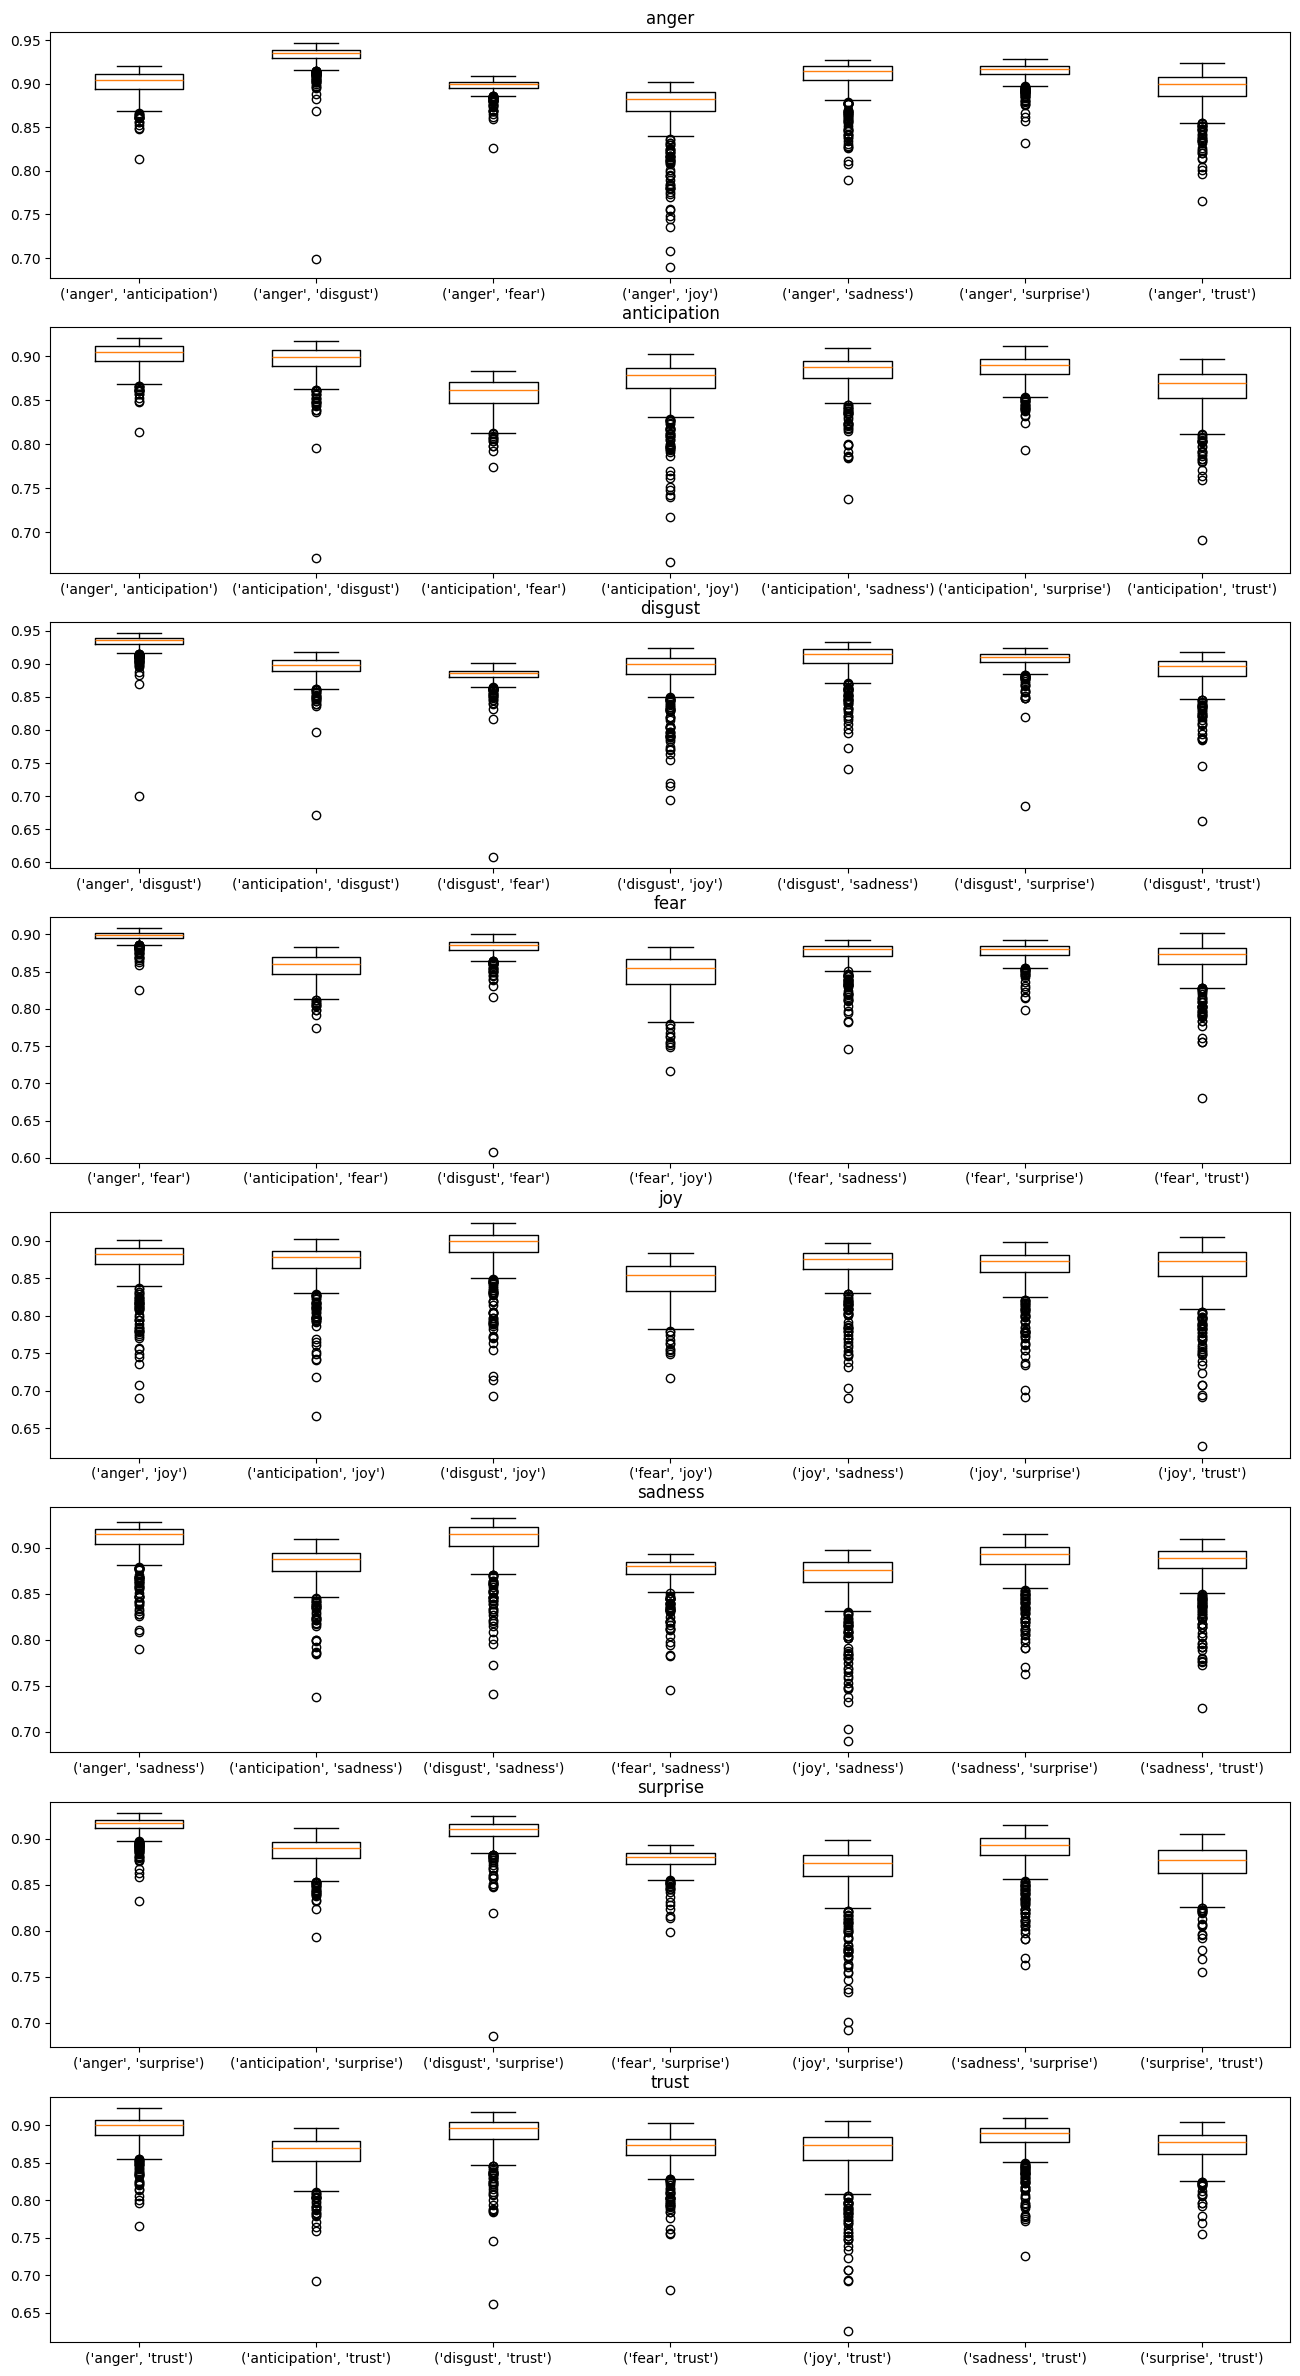

In [65]:
# Boxplots correlacion 
#sent = re.sub(r"[^\w .,;?!\n]+", "", sent)
import re
fig,ax = plt.subplots(8,figsize=(16,30))
columns = words_embbed_w2v_info.columns
i = 0
for emotion in emotion_list:
    data = []
    labels = []
    for column in columns:
        if emotion in column:
            if 'f_' in column:
                continue
            data.append([element[0] for element in words_embbed_w2v_info[column]])
            labels.append(re.sub(r"P_","",column))
    ax[i].boxplot(data)
    ax[i].set_xticklabels(labels)
    ax[i].set_title(emotion)
    i+=1

### Modulacion de embbedings

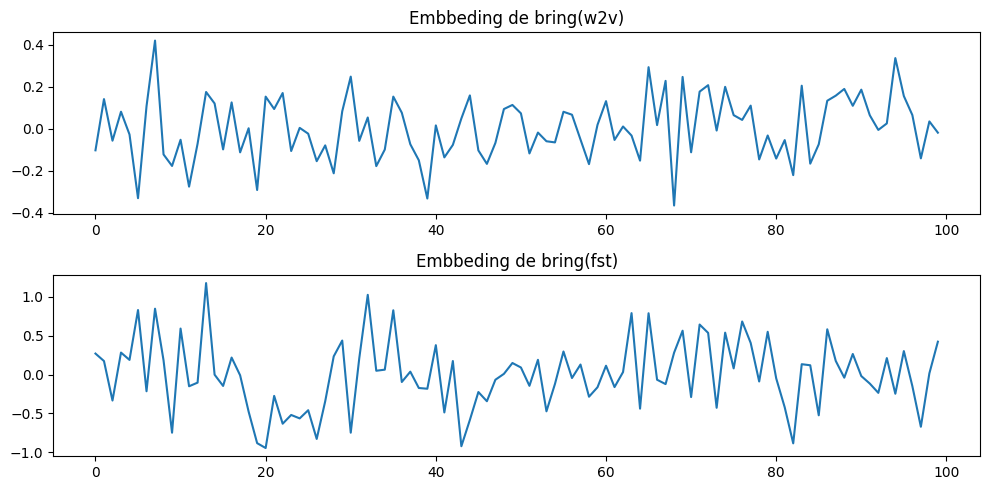

In [67]:
#Emo
word = "bring"
emotion = "anger"
embbed_w2v = poems_w2v[emotion].wv.get_vector(word)
embbed_fst = poems_fst[emotion].wv.get_vector(word)

fig,ax = plt.subplots(2,figsize=(10,5))

ax[0].set_title("Embbeding de "+word+"(w2v)")
ax[0].plot(embbed_w2v)

ax[1].set_title("Embbeding de "+word+"(fst)")
ax[1].plot(embbed_fst)
fig.tight_layout()

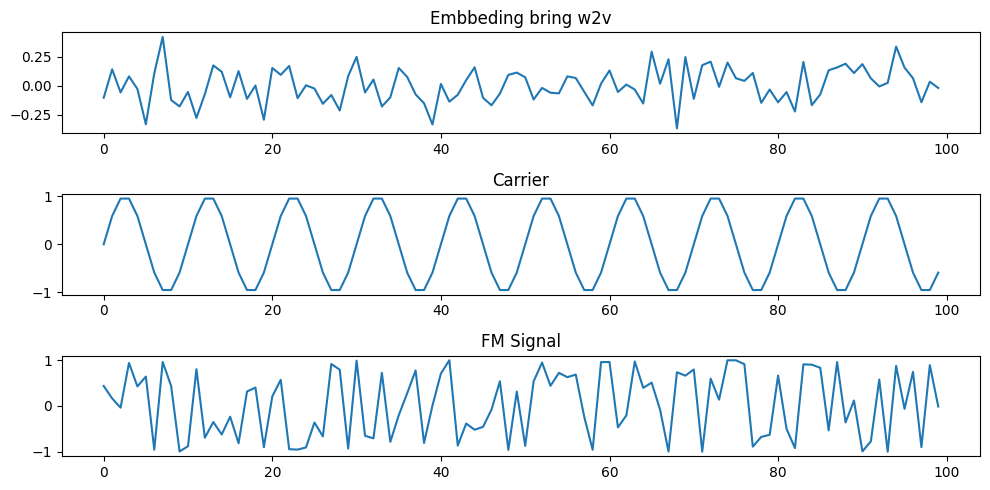

In [110]:
# Samples per second
sps = 100

# Duration
duration_s = 1.0

# ac: amplitude of the carrier. Should be kept at 1.0 in this script

# carrier_hz: Frequency of the carrier
# fm_hz: Frequency of the frequency modulator
# k_p: deviation constant
carrier_amplitude = 1.0
carrier_hz = 10.0
fm_hz = 50.0
k = 50

each_sample_number = np.arange(duration_s * sps)
carrier = 2 * np.pi * each_sample_number * carrier_hz / sps

#modulator = k * np.sin(2 * np.pi * each_sample_number * fm_hz / sps)
modulator = embbed_w2v
# Now create the modulated waveform, and attenuate it
waveform = np.cos(carrier + k*modulator)

fig,ax = plt.subplots(3,figsize=(10,5))
ax[0].set_title("Embbeding "+ word + " w2v")
ax[0].plot(embbed_w2v)

ax[1].set_title("Carrier")
ax[1].plot(np.sin(carrier))

ax[2].set_title("FM Signal")
ax[2].plot(waveform)
fig.tight_layout()

In [ ]:
def modulate(x,carrier_amplitude,carrier_hz,k,sps,duration_s):
    pass